### Künstliche Intelligenz in kleinen und mittleren Betrieben ###
# Analyse der Mohn Filiale Sulgen #

In [54]:
# Importieren wichtiger Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from abc_analysis import abc_analysis # ABC-Analyse Version 1
%pip install inventorize3 # für ABC-Analyse Version 2
import inventorize3 as inv # für ABC-Analyse Version 2

Note: you may need to restart the kernel to use updated packages.


### 1. Einlesen und der Daten und erstes Understanding ###

Zu Beginn importieren wir die Daten und machen uns ein Bild vom Datensatz, seinen Dimensionen und den Wertebereichen.


In [2]:
data  = pd.read_csv("data.csv")
data.head()

,Zeitstempel,Filiale,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag
0,2016-01-03 08:01:46,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN
1,2016-01-03 08:04:45,Sulgen Filiale,Buttergipfeli,2.0,2.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN
2,2016-01-03 08:09:21,Sulgen Filiale,Buttergipfeli,12.0,15.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN
3,2016-01-03 08:11:19,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN
4,2016-01-03 08:11:19,Sulgen Filiale,Buttergipfeli,4.0,5.2,0.0,NaN,0.0,NaN,NaN,0.0,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727754 entries, 0 to 727753
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Zeitstempel                  727754 non-null  object 
 1   Filiale                      727754 non-null  object 
 2   Artikel                      727754 non-null  object 
 3   Menge                        727754 non-null  float64
 4   Umsatz                       727754 non-null  float64
 5   Bestellungen                 727754 non-null  float64
 6   Temperatur                   718722 non-null  float64
 7   Niederschlag                 725226 non-null  float64
 8   Globalstrahlung              718722 non-null  float64
 9   Temperatur Schnitt Tag       719687 non-null  float64
 10  Niederschlag Summe Tag       727754 non-null  float64
 11  Globalstrahlung Schnitt Tag  719687 non-null  float64
dtypes: float64(9), object(3)
memory usage: 66.6+ MB


Jetzt verschaffen wir uns einen Überblick welche Produkte im Datensatz enthalten sind.

In [4]:
n_produkte = data["Artikel"].unique()

# Erstellen einer Produktliste mit der verkauften Anzahl
produkt_liste = data[["Artikel", "Menge", "Umsatz"]].groupby("Artikel").sum()
produkt_liste["Umsatz"] = produkt_liste[["Umsatz"]].round(2)


print("Es sind folgende Produkte im Datensatz enthalten: ")
print(produkt_liste)

Es sind folgende Produkte im Datensatz enthalten: 
                           Menge     Umsatz
Artikel                                    
BT Nussgipfel            64025.3  171619.78
Buttergipfeli           384812.0  516096.18
Butterzopf mittel        62872.0  395181.16
Crèmeschnitten           71149.0  241427.88
Erdbeertörtli            26901.0  113210.62
Hefe-Vanille-Weggli      40206.0  100220.33
Il pollo forte gefüllt   42164.0  316108.05
Laugenbrötli             95970.0   95867.92
Laugengi.mit SoBlu      187591.0  281656.65
Maisgipfel              180437.6  270913.79
Quarkzöpfli              63098.0  245454.58
Schoggibrötli            43954.0  103507.96
St. Gallerbürli          79307.0  110888.58
Weggli normal            83320.0   91583.08


<font color=red>
<b> Offene Fragen: </b>

Warum gibt es bei Nussgipfel und Maisgipfel Dezimalstellen?
</font>


### 2. Vorbereitung des Dataframes ###

Als nächstes bereiten wir den Datensatz auf. 

Dafür werden :
- Spalten transformiert
- Ungenutzte Spalten entfernt
- NA Werte gefüllt oder entfernt
- Outlier aus dem Datensatz entfernt


#### 2.1. Transformation ganzer Spalten im Dataframe ####

In [5]:
data_backup = data.copy()

# Transformation des Datensatzes
data["Zeitstempel"] = pd.to_datetime(data["Zeitstempel"])
data["Uhrzeit"] = pd.to_datetime(data["Zeitstempel"]).dt.time
data["Stunde"] = pd.to_datetime(data["Zeitstempel"]).dt.hour
data["Datum"] = pd.to_datetime(data["Zeitstempel"]).dt.date
data["Wochentag"] = pd.to_datetime(data["Zeitstempel"]).dt.day_name()

data.head()

,Zeitstempel,Filiale,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag
0,2016-01-03 08:01:46,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday
1,2016-01-03 08:04:45,Sulgen Filiale,Buttergipfeli,2.0,2.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday
2,2016-01-03 08:09:21,Sulgen Filiale,Buttergipfeli,12.0,15.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday
3,2016-01-03 08:11:19,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday
4,2016-01-03 08:11:19,Sulgen Filiale,Buttergipfeli,4.0,5.2,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727754 entries, 0 to 727753
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Zeitstempel                  727754 non-null  datetime64[ns]
 1   Filiale                      727754 non-null  object        
 2   Artikel                      727754 non-null  object        
 3   Menge                        727754 non-null  float64       
 4   Umsatz                       727754 non-null  float64       
 5   Bestellungen                 727754 non-null  float64       
 6   Temperatur                   718722 non-null  float64       
 7   Niederschlag                 725226 non-null  float64       
 8   Globalstrahlung              718722 non-null  float64       
 9   Temperatur Schnitt Tag       719687 non-null  float64       
 10  Niederschlag Summe Tag       727754 non-null  float64       
 11  Globalstrahlung Schnitt Ta

In [7]:
# Konvertieren der Spalten in die richtige Datentypen
data["Datum"] = pd.to_datetime(data["Datum"]).dt.date
wochentag_reihenfolge = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data["Wochentag"] = pd.Categorical(data["Wochentag"], categories = wochentag_reihenfolge, ordered = True)

# Entfernen nicht mehr benötigter Spalten
data = data.drop(columns = ["Filiale", "Zeitstempel"], axis = "columns")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727754 entries, 0 to 727753
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Artikel                      727754 non-null  object  
 1   Menge                        727754 non-null  float64 
 2   Umsatz                       727754 non-null  float64 
 3   Bestellungen                 727754 non-null  float64 
 4   Temperatur                   718722 non-null  float64 
 5   Niederschlag                 725226 non-null  float64 
 6   Globalstrahlung              718722 non-null  float64 
 7   Temperatur Schnitt Tag       719687 non-null  float64 
 8   Niederschlag Summe Tag       727754 non-null  float64 
 9   Globalstrahlung Schnitt Tag  719687 non-null  float64 
 10  Uhrzeit                      727754 non-null  object  
 11  Stunde                       727754 non-null  int64   
 12  Datum                        727754 non-null

In [8]:
print("Der Datensatz geht von {} bis {}.".format(data["Datum"].min(), data["Datum"].max()))

Der Datensatz geht von 2016-01-03 bis 2022-02-11.


In [9]:
data.head()

,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag
0,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday
1,Buttergipfeli,2.0,2.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday
2,Buttergipfeli,12.0,15.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday
3,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday
4,Buttergipfeli,4.0,5.2,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday


#### 2.2 Trimmen des Datensatzes ####

Im nächsten Schritt werden Outlier aus dem Datensatz gelöscht.

In [10]:
# Im nächsten Schritt prüfen wir Transaktionen außerhalb der Öffnungszeiten. Im Maximum hat die Bäckerrei von 5:30 bis 19:00 geöffnet.
# Zu erst werden Transaktionen vor Öffnung geprüft.
data_4_uhr = data[data["Stunde"] == 4]
data_4_uhr.head()

# Da sich in einem Histogramm über den Umsatz pro Uhrzeit pro Tag Ausreißer um 4 Uhr finden, werden alle Einträge vor 5 Uhr entfernt.
data = data[data["Stunde"] >= 5]

In [11]:
# 
data_20_uhr = data[data["Stunde"] == 20]
data_20_uhr.head()

,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag
28671,Hefe-Vanille-Weggli,1.0,1.7553,0.0,11.5,0.0,0.0,11.441667,0.0,257.291667,20:01:02,20,2016-04-21,Thursday
28672,BT Nussgipfel,1.0,1.9947,0.0,11.5,0.0,0.0,11.441667,0.0,257.291667,20:01:02,20,2016-04-21,Thursday


Nun löschen wir alle Duplikate im Dataframe

In [12]:
data.drop_duplicates(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719185 entries, 0 to 727753
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Artikel                      719185 non-null  object  
 1   Menge                        719185 non-null  float64 
 2   Umsatz                       719185 non-null  float64 
 3   Bestellungen                 719185 non-null  float64 
 4   Temperatur                   710279 non-null  float64 
 5   Niederschlag                 716688 non-null  float64 
 6   Globalstrahlung              710279 non-null  float64 
 7   Temperatur Schnitt Tag       711227 non-null  float64 
 8   Niederschlag Summe Tag       719185 non-null  float64 
 9   Globalstrahlung Schnitt Tag  711227 non-null  float64 
 10  Uhrzeit                      719185 non-null  object  
 11  Stunde                       719185 non-null  int64   
 12  Datum                        719185 non-null

Da der Datensatz sowohl 719185 Werte vor und nach dem Löschen hatte, kann man davon ausgehen, dass es keine Duplikate gab.

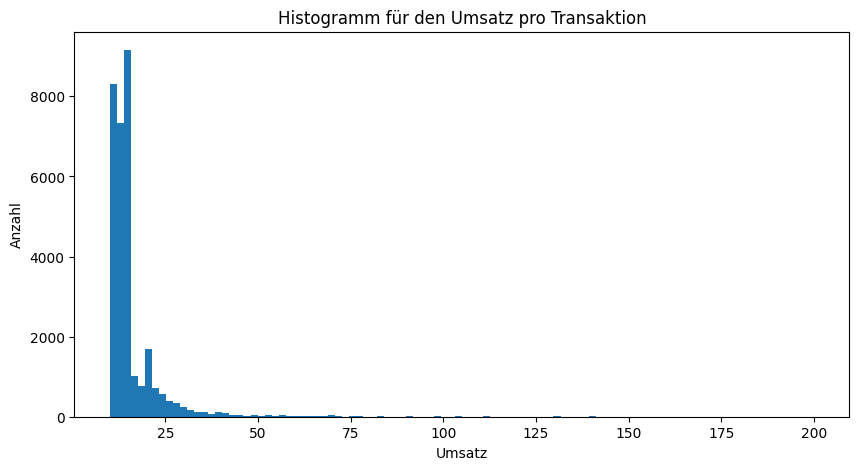

In [13]:
# Erstellen eines Histogramms für den Umsatz pro Transaktion
plt.figure(figsize= (10, 5))
plt.hist(data["Umsatz"], bins = 100, range= [10,200])
plt.title("Histogramm für den Umsatz pro Transaktion")
plt.xlabel("Umsatz")
plt.ylabel("Anzahl")
plt.show()

### 3. Erste Plots ###

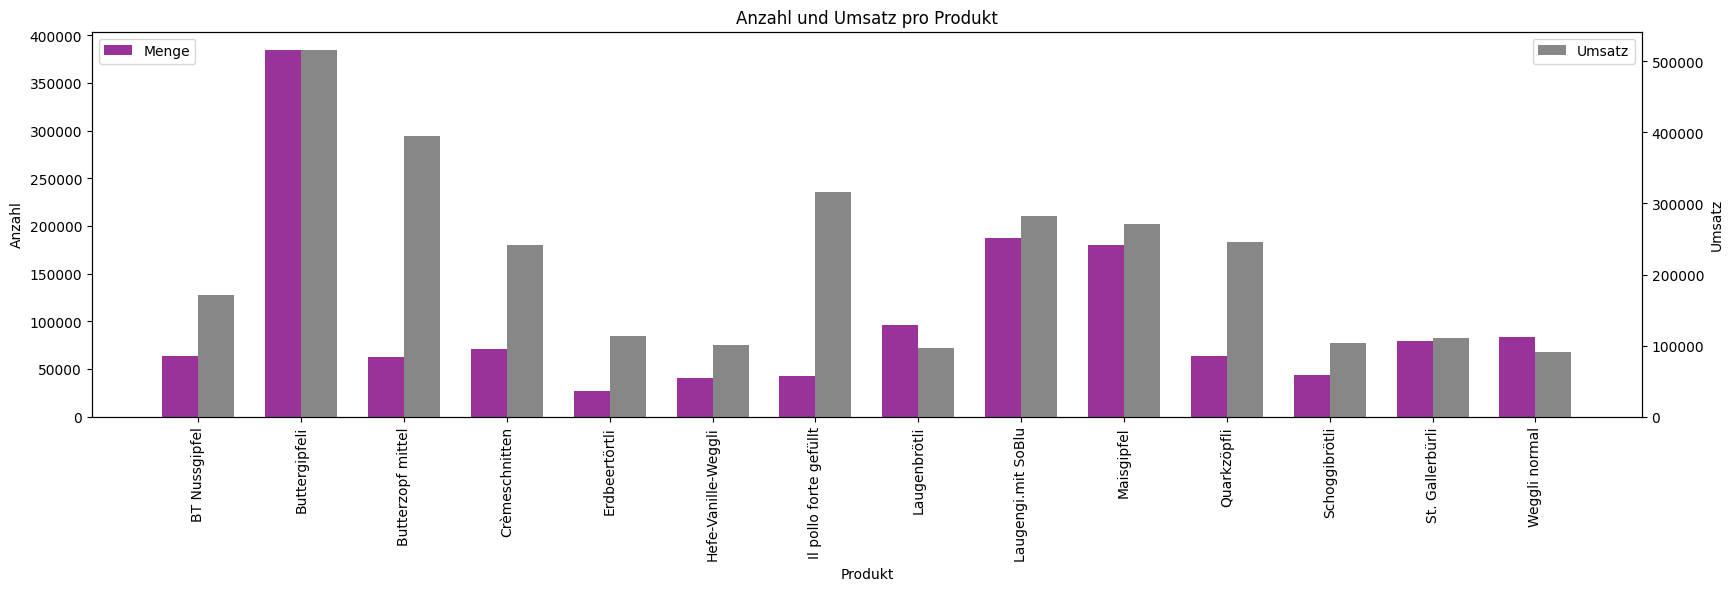

In [14]:
# Erstellen einer Grafik mit Anzahl und Umsatz pro Produkt
fig, ax = plt.subplots(figsize=(20, 5)) 
index = np.arange(len(produkt_liste))
bar_width = 0.35
opacity = 0.8

menge_bar = plt.bar(index, produkt_liste["Menge"], bar_width,
    alpha=opacity,
    color='purple',
    label='Menge')

plt.xlabel('Produkt')
plt.ylabel('Anzahl')
plt.title('Anzahl und Umsatz pro Produkt')
plt.xticks(index + bar_width/2, produkt_liste.index), plt.xticks(rotation=90)

# Erschaffen einer zweiten Achse für Umsatz
ax2 = ax.twinx()
ax2.set_ylabel('Umsatz')

# 
umsatz_bar = plt.bar(index + bar_width, produkt_liste["Umsatz"], bar_width,
    alpha=opacity,
    color='dimgray',
    label='Umsatz')

# Verbinden beider Legenden
ax.legend(loc = "upper left")
ax2.legend(loc = "upper right")

plt.show()


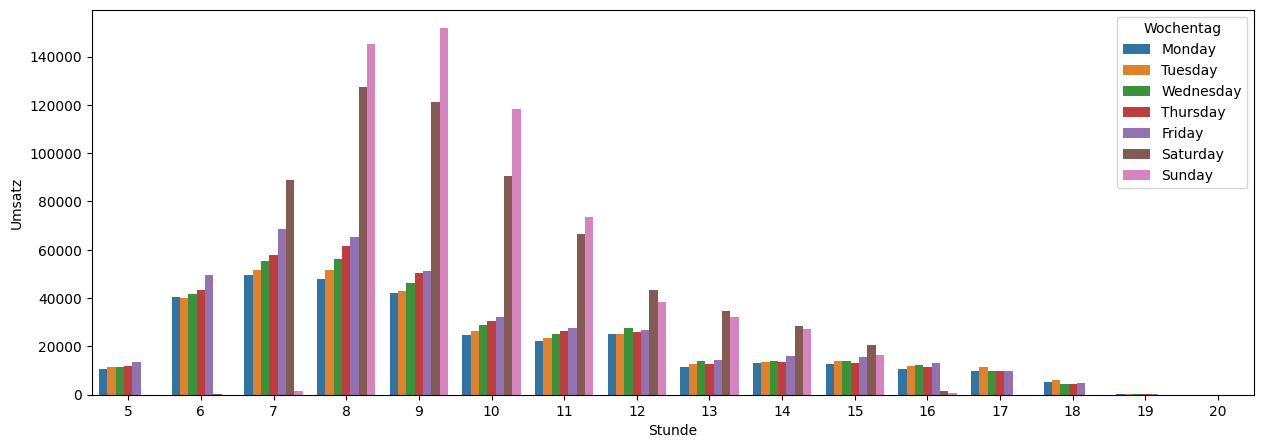

In [15]:
# Erstellen eines Plots mit Uhrzeit und Umsatz

# Gruppieren der Daten nach Uhrzeit und Wochentag und berechnung des Durchschnittlichen Umsatzes
avg_umsatz = data.groupby(["Stunde", "Wochentag"])["Umsatz"].sum().reset_index()

#Erstellen des Plots
plt.figure(figsize = (15,5))
sns.barplot(data = avg_umsatz, x = "Stunde", y = "Umsatz", hue = "Wochentag")

ax.set_xlabel("Uhrzeit")
ax.set_ylabel("Umsatz")
ax.set_title("Umsatz pro Stunde pro Wochentag")
ax.legend(title = "Wochentag", loc = "upper right")
plt.show()


In [16]:
# Test änderung

In [17]:
# Test änderung 2

# 4. Korrelationsmatrix

In [22]:
corr = data.corr()

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr.style.background_gradient(cmap).format(precision=2)

/var/folders/5v/myjjmnq90k1fyxc9y1gychkh0000gn/T/ipykernel_1197/4101275082.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Stunde
Menge,1.00,0.73,0.11,-0.02,-0.00,-0.03,0.00,0.00,0.00,-0.10
Umsatz,0.73,1.00,-0.04,0.02,-0.00,0.03,0.00,0.00,0.01,0.05
Bestellungen,0.11,-0.04,1.00,-0.07,0.00,-0.06,-0.04,0.01,-0.08,-0.11
Temperatur,-0.02,0.02,-0.07,1.00,-0.02,0.69,0.94,0.07,0.72,0.19
Niederschlag,-0.00,-0.00,0.00,-0.02,1.00,-0.16,-0.00,0.46,-0.14,0.02
Globalstrahlung,-0.03,0.03,-0.06,0.69,-0.16,1.00,0.58,-0.14,0.78,0.11
Temperatur Schnitt Tag,0.00,0.00,-0.04,0.94,-0.00,0.58,1.00,0.08,0.74,-0.03
Niederschlag Summe Tag,0.00,0.00,0.01,0.07,0.46,-0.14,0.08,1.00,-0.19,0.00
Globalstrahlung Schnitt Tag,0.00,0.01,-0.08,0.72,-0.14,0.78,0.74,-0.19,1.00,-0.03
Stunde,-0.10,0.05,-0.11,0.19,0.02,0.11,-0.03,0.00,-0.03,1.00


# 5.1 ABC-Analyse (Version 1)

In [24]:
# Quelle: https://www.youtube.com/watch?v=g0W8e7na16k&t=287s
# Wir müssen den Datensatz zunächst umformen. Wir benötigen lediglich die unterschiedlichen Artikel (inkl. Menge & Umsatz pro Artikel)
dataABC = data.groupby(['Artikel']).agg(Menge=('Menge',np.sum),Umsatz=('Umsatz',np.sum)).reset_index()


In [25]:
# Datensatz
dataABC.head()

,Artikel,Menge,Umsatz
0,BT Nussgipfel,63750.3,170888.1839
1,Buttergipfeli,380642.5,510542.0167
2,Butterzopf mittel,62808.0,394777.3602
3,Crèmeschnitten,70883.0,240532.9746
4,Erdbeertörtli,26792.0,112765.2629


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/abc_analysis/abc_analysis.py:163: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = pd.Series([0]).append(y)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/abc_analysis/abc_analysis.py:164: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x = pd.Series([0]).append(x)


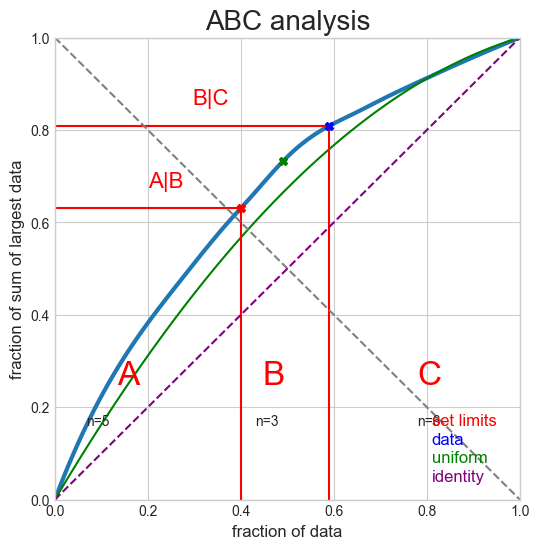

In [47]:
abc_umsatz = abc_analysis(dataABC['Umsatz'], True)


In [50]:
# abc_menge = abc_analysis(dataABC['Menge'], True)

In [48]:
# Nun wollen wir jeden Artikel kategorisieren

a_index = abc['Aind']
b_index = abc['Bind']
c_index = abc['Cind']

# Neue Spalte im Datensatz mit der Kategorisierung

cond_list = [dataABC.index.isin(a_index),
             dataABC.index.isin(b_index),
             dataABC.index.isin(c_index),
             ]

choice_list = ['A', 'B', 'C']

dataABC['Kategorie'] = np.select(cond_list, choice_list)
dataABC.sort_values(by=['Kategorie'])



,Artikel,Menge,Umsatz,Kategorie
1,Buttergipfeli,380642.5,510542.0167,A
2,Butterzopf mittel,62808.0,394777.3602,A
6,Il pollo forte gefüllt,42087.0,315529.6546,A
8,Laugengi.mit SoBlu,186385.0,279846.3822,A
9,Maisgipfel,179040.6,268815.9906,A
0,BT Nussgipfel,63750.3,170888.1839,B
3,Crèmeschnitten,70883.0,240532.9746,B
10,Quarkzöpfli,62926.0,244785.0807,B
4,Erdbeertörtli,26792.0,112765.2629,C
5,Hefe-Vanille-Weggli,39990.0,99684.7256,C


In [58]:
dataABC

,Artikel,Menge,Umsatz,Kategorie
0,BT Nussgipfel,63750.3,170888.1839,B
1,Buttergipfeli,380642.5,510542.0167,A
2,Butterzopf mittel,62808.0,394777.3602,A
3,Crèmeschnitten,70883.0,240532.9746,B
4,Erdbeertörtli,26792.0,112765.2629,C
5,Hefe-Vanille-Weggli,39990.0,99684.7256,C
6,Il pollo forte gefüllt,42087.0,315529.6546,A
7,Laugenbrötli,95742.5,95640.4229,C
8,Laugengi.mit SoBlu,186385.0,279846.3822,A
9,Maisgipfel,179040.6,268815.9906,A


# 5.2 ABC-Analyse (Version 2)

In [53]:
# Quelle: https://www.youtube.com/watch?v=V8Mz91gaXmQ&t=1075s
# Anmerkung: Resultat bzw. Klassifizierung ist nich gleich wie bei der Version 1. Deshalb habe ich beides mal drin gelassen.
#            Muss man noch angeschaut werden. 

# Wir müssen den Datensatz zunächst umformen. Wir benötigen lediglich die unterschiedlichen Artikel (inkl. Menge & Umsatz pro Artikel)
data_abc = data.groupby(['Artikel']).agg(Menge=('Menge',np.sum),Umsatz=('Umsatz',np.sum)).reset_index()

data_abc.head()

,Artikel,Menge,Umsatz
0,BT Nussgipfel,63750.3,170888.1839
1,Buttergipfeli,380642.5,510542.0167
2,Butterzopf mittel,62808.0,394777.3602
3,Crèmeschnitten,70883.0,240532.9746
4,Erdbeertörtli,26792.0,112765.2629


In [63]:
# Nun klassifizieren wir die Produkte (A, B und C)

data_abc_analyse = inv.ABC(data_abc[['Artikel','Umsatz']])

In [64]:
# Nun wurde der Datensatz mit der Spalte "Category" erweitert.  
data_abc_analyse

,Artikel,Umsatz,Percentage,comulative,Category
1,Buttergipfeli,510542.0167,0.168006,0.168006,A
2,Butterzopf mittel,394777.3602,0.129911,0.297917,A
6,Il pollo forte gefüllt,315529.6546,0.103833,0.401749,A
8,Laugengi.mit SoBlu,279846.3822,0.092090,0.493839,A
9,Maisgipfel,268815.9906,0.088460,0.582300,A
10,Quarkzöpfli,244785.0807,0.080552,0.662852,A
3,Crèmeschnitten,240532.9746,0.079153,0.742005,A
0,BT Nussgipfel,170888.1839,0.056235,0.798240,A
4,Erdbeertörtli,112765.2629,0.037108,0.835348,B
12,St. Gallerbürli,110594.5840,0.036394,0.871742,B


In [66]:
# Count of categories
data_abc_analyse.Category.value_counts()

# Resultat: 8 Artikel sind A-Produkte, 4 Artikel sind B-Produkte und 2 Artikel sind C-Produkte.

A    8
B    4
C    2
Name: Category, dtype: int64

In [68]:
# Nun wollen wir noch wissen wie viel Prozent der Verkauften Artikel die A,B und C-Produkte ausmachen. 

data_ABC_summary = data_abc_analyse.groupby('Category').agg(Count=('Artikel', np.count_nonzero),Prozentsatz=('Percentage',np.sum)).reset_index()
data_ABC_summary['Prozentsatz']=data_ABC_summary['Prozentsatz']*100
data_ABC_summary

# Resultat: Die A-Produkte machen 79.8% aus, die B-Produkte 14.02% und die C-Produkte 6.2%. 

,Category,Count,Prozentsatz
0,A,8,79.824000
1,B,4,14.024812
2,C,2,6.151188


<Axes: xlabel='Category', ylabel='count'>

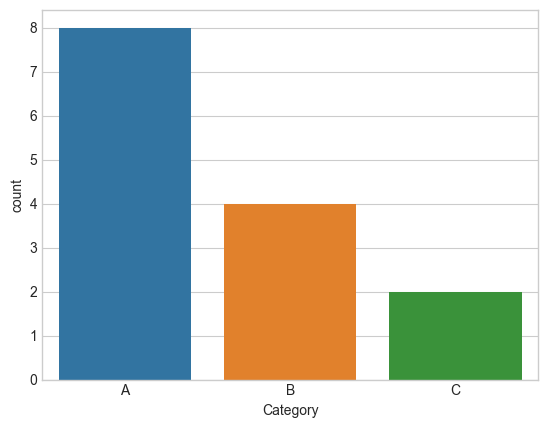

In [69]:
# Visualisierung der ABC Analyse

sns.countplot(x='Category', data=data_abc_analyse, label=True)

<Axes: xlabel='Category', ylabel='Umsatz'>

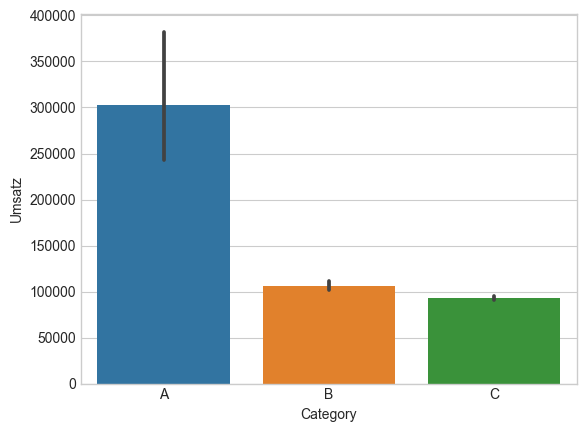

In [71]:
# Visualisierung ABC Analyse nach volume of sales

sns.barplot(x='Category', y='Umsatz', data=data_abc_analyse)

# 6. High-Level Analyse 

In [76]:
# Hier möchten wir sehen, wie sich der Umsatz im Verlauf der Jahre entwickelt hat. 
# Zunächst wird der Datensatz umstrukturiert. Wir möchten den Umsatz pro Tag. 

data_2 = data.groupby(['Datum']).agg(Umsatz=('Umsatz',np.sum)).reset_index()
data_2

,Datum,Umsatz
0,2016-01-03,1175.5000
1,2016-01-04,795.1618
2,2016-01-05,512.7082
3,2016-01-06,654.0417
4,2016-01-07,751.9000
...,...,...
2173,2022-02-07,1258.6000
2174,2022-02-08,1417.0500
2175,2022-02-09,1554.7000
2176,2022-02-10,1529.1000


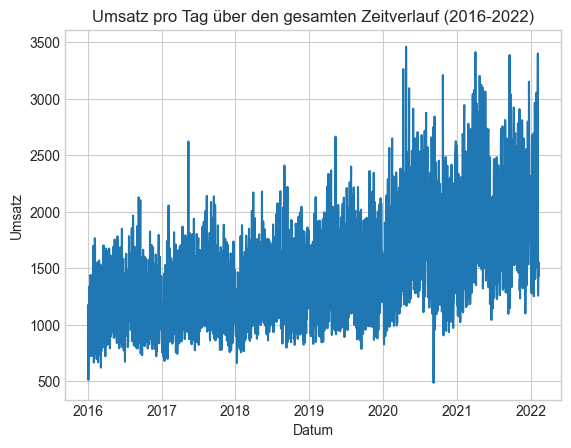

In [77]:
# Visualisierung: Umsatz pro Tag

plt.plot(data_2['Datum'], data_2['Umsatz'])
plt.xlabel('Datum')
plt.ylabel('Umsatz')
plt.title('Umsatz pro Tag über den gesamten Zeitverlauf (2016-2022)')
plt.show()


In [81]:
# Visualisierung: Umsatz pro Monat

# Dafür müssen wir den Datensatz so umformen, dass wir den Umsatz pro Monat haben.


0         1
1         1
2         1
3         1
4         1
         ..
727749    1
727750    1
727751    1
727752    1
727753    1
Name: Datum, Length: 719185, dtype: int64

# † Code Graveyard † #

In [18]:
# Tag + Uhrzeit mit maximalem Umsatz
max_umsatz = data[data["Umsatz"] == data["Umsatz"].max()]
max_umsatz_Tag = max_umsatz["Wochentag"].values[0]
max_umsatz_stunde = max_umsatz["Uhrzeit"].values[0]
print("Der höchste Umsatz wurde am {} um {} Uhr erzielt.".format(max_umsatz_Tag, max_umsatz_stunde))



Der höchste Umsatz wurde am Sunday um 15:51:41 Uhr erzielt.
